In [1]:
import pandas as pd
import requests
import bs4

ImportError: No module named 'bs4'

In [ ]:
current_dep_scrape = 'http://w1.c1.rada.gov.ua/pls/site2/fetch_mps?skl_id=9&district=y'



In [ ]:
links = [{'name':'2002', 'year':2012, 'link': 'https://w1.c1.rada.gov.ua/pls/site2/fetch_mps?skl_id=5&district=y'},
{'name':'2012','year':2014, 'link':'https://w1.c1.rada.gov.ua/pls/site2/fetch_mps?skl_id=8&district=y'},
 {'name':'2014','year':2019, 'link':'http://w1.c1.rada.gov.ua/pls/site2/fetch_mps?skl_id=9&district=y'}]


my_data = {};
for election in links:
    soup = bs4.BeautifulSoup(requests.get(election['link']).content)

    a = [d.text for d in soup.select('ul li p.title a')]
    b = [d.text.split('№')[1] for d in soup.select('ul li dd') if 'округу' in d.text]
    c = election['year']

    my_data[election['name']] = pd.DataFrame({'full_name': a,'smd': b, 'year':c})
    


In [ ]:
previous_winners = pd.concat(list(my_data.values()), axis=0)

In [ ]:
previous_winners.to_csv('previous_winners.csv', index=False)

In [ ]:
subv_2018 = pd.read_csv('https://raw.githubusercontent.com/OPORA/rada/master/subventions/subventions2018/MPs2018.csv')
subv_2018_short = subv_2018[['smd', 'amount']]

In [ ]:
parl = pd.read_csv('parl_2019.csv')

In [ ]:
parl['Висування'].value_counts().reset_index().to_csv('parties_2019', index=False)

In [ ]:
pres = pd.read_csv('pres_2019.tsv', sep='\t')
pres_tvo = pres.groupby(['tvo', 'oblast'])['БалашовГеннадій',
       'БезсмертнийРоман', 'БогомолецьОльга', 'БогословськаІнна', 'БойкоЮрій',
       'БондарВіктор', 'ВащенкоОлександр', 'ВілкулОлександр', 'ГаберМикола',
       'ГриценкоАнатолій', 'ДанилюкОлександр', 'Дерев’янкоЮрій',
       'ЖуравльовВасиль', 'ЗеленськийВолодимир', 'КаплінСергій',
       'КармазінЮрій', 'КиваІлля', 'КорнацькийАркадій', 'КошулинськийРуслан',
       'КривенкоВіктор', 'КупрійВіталій', 'ЛитвиненкоЮлія', 'ЛяшкоОлег',
       'МорозОлександр', 'НаливайченкоВалентин', 'НасіровРоман', 'НовакАндрій',
       'НосенкоСергій', 'ПетровВолодимир', 'ПорошенкоПетро', 'РиговановРуслан',
       'СкоцикВіталій', 'СмешкоІгор', 'СоловйовОлександр', 'ТарутаСергій',
       'ТимошенкоЮлія', 'ТимошенкоЮрій', 'ШевченкоІгор', 'ШевченкоОлександр'].sum()

pres_tvo.reset_index(inplace=True)

In [ ]:
party_names_and_cands = parl['Висування'].value_counts().reset_index()
party_names_and_cands['candidat_pres'] =  pd.Series([np.nan,'ЗеленськийВолодимир', 'БойкоЮрій', 'ТимошенкоЮлія', np.nan, 'ПорошенкоПетро', np.nan, 'СмешкоІгор', np.nan, 'ЛяшкоОлег'])
# party_names_and_cands = party_names_and_cands.fillna('Самовисування')

In [ ]:
pres_tvo_melted = pd.melt(pres_tvo,id_vars=['tvo', 'oblast'],
        value_name='n_vbtes')

In [ ]:
party_names_and_cands.columns

In [ ]:
parl_with_pres_name = pd.merge(parl, party_names_and_cands[['index', 'candidat_pres']],
         left_on='Висування', right_on="index", how='left')

In [ ]:
# parl_with_pres_name['Округ', 'candidat_pres']
# pres_tvo_melted['tvo', 'variable']

In [ ]:
data_for_prediction = pd.merge(parl_with_pres_name, pres_tvo_melted, left_on=['Округ', 'candidat_pres'],
         right_on=['tvo', 'variable'], how='left')

In [ ]:
data_for_prediction = data_for_prediction[['ПІБ', 'Округ', 'Висування', 'Область', 'n_vbtes']]
data_for_prediction.columns = ['candidat_name', 'tvo', 'party_name', 'oblast_name', 'pres_cand_result']
data_for_prediction

In [ ]:
subv_2018['smd'] = subv_2018.smd.astype('str')
combined_subv = pd.merge(subv_2018[['smd', 'mp_name', 'amount']], winners_2019, on='smd', how='left')

In [ ]:
data_for_prediction['tvo'] = data_for_prediction.tvo.astype('str') 
merged_subv = pd.merge(data_for_prediction, combined_subv,
         left_on=['tvo'], right_on=['smd'], how='left')

In [ ]:
merged_subv[merged_subv.compare > 0.85].sort_values('compare')

In [ ]:
# помилка тому, що є НА в назвах, а вони є тому, що субвенції були не у всіх округах. Краще на це забити і взяти 
# переможців з попереднього файла

from difflib import SequenceMatcher

merged_subv.full_name = merged_subv.full_name.fillna('1')

def compare(x):
    return SequenceMatcher(None, x['candidat_name'], x['full_name']).ratio()

merged_subv['compare'] = merged_subv.apply(lambda x: compare(x), axis=1)
merged_subv['winner'] = merged_subv.compare.apply(lambda x: x > 0.9)


In [ ]:
np.nan

In [ ]:
def change(x):
    if (x['winner'] == True):
        return x['amount']
    else:
        return np.nan
        

merged_subv['amount'] = merged_subv.apply(lambda x: change(x), axis=1)

In [ ]:
merged_subv_short =  merged_subv.drop(['mp_name', 'full_name', 'compare'], axis=1)
merged_subv_short.columns = ['candidat_name', 'tvo', 'party_name', 'oblast_name', 'pres_cand_result',
       'smd', 'amount', 'previous_election_winner']
merged_subv_short.to_csv('for_2019_pred_unfinished.csv', index=False)

In [ ]:
merged_subv['winner'] = merged_subv.compare.apply(lambda x: x > 0.9)

In [ ]:
merged_subv_short

In [ ]:
merged_subv_short[merged_subv_short.party_name == 0]

In [ ]:
load_csv.iloc[2,:]

# Model

In [ ]:
import h2o

# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = 6)

In [ ]:
# load_csv = "combined_results.csv"  # modify this for your machine

# load_csv = pd.read_csv(load_csv)


In [ ]:
# t = load_csv.loc[load_csv.winner == True]
# f = load_csv.loc[load_csv.winner == False]

# f_short = f.sample(len(t))

In [ ]:
loan_csv = "combined_results.csv"  # modify this for your machine
# Alternatively, you can import the data directly from a URL
# loan_csv = "https://raw.githubusercontent.com/h2oai/app-consumer-loan/master/data/loan.csv"
# data = h2o.H2OFrame(data)  # 163,987 rows x 15 columns

# df = pd.read_csv(loan_csv)
# df = df.drop_duplicates()

# previous_winners['was_in_power'] = True
# previous_winners.columns = ['deputat', 'tvo', 'year', 'was_in_power']
# previous_winners.tvo = previous_winners.tvo.astype('int64')

# df = pd.merge(df, previous_winners, on=['deputat', 'tvo', 'year'], how='left')
# df.was_in_power = df.was_in_power.fillna(False)


# data = h2o.H2OFrame(df)
data = h2o.import_file(loan_csv)

In [ ]:
# train_pd = df.loc[df.year == 2012]
# test_pd = df.loc[df.year == 2014]


In [ ]:
# from sklearn.utils import shuffle

# t = train_pd.loc[load_csv.winner == True]
# f = train_pd.loc[load_csv.winner == False]

# f_short = f.sample(len(t))

# d = pd.concat([t,f_short], axis=0)
# train_pd_short = shuffle(d)


# train = h2o.H2OFrame(train_pd_short)
# test = h2o.H2OFrame(test_pd)

In [ ]:
data = data.drop(['perc_for', 'votes_for'])

In [ ]:
# Partition data into 70%, 15%, 15% chunks
# Setting a seed will guarantee reproducibility

# Split data into train and testing
train, test = data.split_frame(ratios=[0.8])

# train = data_prepared[data_prepared[:,'year'] == 2012]
# test = data_prepared[data_prepared[:,'year'] == 2014]

Identify response and predictor variables¶ 

In [ ]:
y = 'winner'
x = list(data.columns)

x.remove(y)  #remove the response
x.remove('pres_perc_for')  #remove the interest rate column because it's correlated with the outcome



In [ ]:
# Import H2O RF:
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [ ]:
rf_fit1 = H2ORandomForestEstimator(model_id='rf_fit1', max_depth=10, seed=1)

In [ ]:
rf_fit1.train(x=x, y=y, training_frame=train)

Train an RF with more trees¶

In [ ]:
rf_fit2 = H2ORandomForestEstimator(model_id='rf_fit2', ntrees=100, seed=1)
rf_fit2.train(x=x, y=y, training_frame=train)

In [ ]:
# rf_fit3 = H2ORandomForestEstimator(model_id='rf_fit3', seed=1, nfolds=5)
# rf_fit3.train(x=x, y=y, training_frame=data)

In [ ]:
from h2o.estimators import H2OXGBoostEstimator
model = H2OXGBoostEstimator(
#     silent=False, 
#                       scale_pos_weight=1,
#                       learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
#                       objective='binary:logistic', 
#                       n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
gamma=10.0)
model.train(x=x, y=y, training_frame=train)

In [ ]:
xgboost_perf1 = model.model_performance(test)


In [ ]:
rf_perf1 = rf_fit1.model_performance(test)
rf_perf2 = rf_fit2.model_performance(test)
# rf_perf3 = rf_fit3.model_performance(test)
xgboost_perf1 = model.model_performance(test)


# Retreive test set AUC
print (rf_perf1.auc())
print (rf_perf2.auc())
xgboost_perf1.auc()

# print (rf_perf3.auc())




In [ ]:
xgboost_perf1

In [ ]:
rf_perf1.confusion_matrix()


In [ ]:
pd.DataFrame(model.varimp()) 

In [ ]:
final_pred = rf_fit2.predict(test.drop('winner'))


In [ ]:
test[170,]

In [ ]:
import sys
sys.getdefaultencoding()


In [ ]:
test.as_data_frame()

In [ ]:
check_result = test.concat(final_pred,axis=1).as_data_frame(use_pandas=True)



In [ ]:
def check(x):
    if (x['predict'] == x['winner'] == True):
        return 'true_positive'
    if (x['predict'] == x['winner'] == False):
        return 'true_negative'
    if (x['predict'] > x['winner']):
        return "false_positive"
    if (x['predict'] < x['winner']):
        return 'false_negative'

check_result['status'] = check_result.apply(lambda x: check(x), axis=1)

In [ ]:
check_result.winner.value_counts()

In [ ]:
check_result.status.value_counts()

In [ ]:
check_result

In [ ]:
highest_prob = check_result.groupby(['tvo', 'year'], sort=False)['True'].max().reset_index(name='highest_prob')

check_result = pd.merge(check_result, highest_prob, on=['tvo', 'year'], how='left')

In [ ]:
check_result.predict.value_counts()

In [ ]:
len(check_result)

In [ ]:
check_result['manual_check_winner'] = check_result.apply(lambda x: x['True'] == x['highest_prob'], axis=1)

In [ ]:
check_result[check_result.apply(lambda x: (x['winner'] != x['manual_check_winner']), axis=1)].proposed.value_counts()

In [ ]:
check_result.loc[check_result.tvo == 25].sort_values('True', ascending=False)[['True', 'deputat', 'partia','manual_check_winner', 'winner']]

In [ ]:
check_result[(check_result.winner == True) & (check_result.manual_check_winner == False)]

In [ ]:
check_result[check_result.manual_check_winner != check_result.winner].partia.value_counts()

## gradient boosting

In [ ]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

gbm_fit1 = H2OGradientBoostingEstimator(model_id='gbm_fit1', seed=1)
gbm_fit1.train(x=x, y=y, training_frame=train)

gbm_fit2 = H2OGradientBoostingEstimator(model_id='gbm_fit2', ntrees=500, seed=1)
gbm_fit2.train(x=x, y=y, training_frame=train)

In [ ]:
gbm_fit3 = H2OGradientBoostingEstimator(model_id='gbm_fit3', 
                                        ntrees=500, 
                                        score_tree_interval=5,     #used for early stopping
                                        stopping_rounds=3,         #used for early stopping
                                        stopping_metric='AUC',     #used for early stopping
                                        stopping_tolerance=0.0005, #used for early stopping
                                        seed=1)

# The use of a validation_frame is recommended with using early stopping
gbm_fit3.train(x=x, y=y, training_frame=train, validation_frame=valid)

In [ ]:
gbm_perf1 = gbm_fit1.model_performance(test)
gbm_perf2 = gbm_fit2.model_performance(test)
gbm_perf3 = gbm_fit3.model_performance(test)

# not h2o

In [14]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

In [2]:
data = pd.read_csv('combined_results.csv')

In [ ]:
# from sklearn.utils import shuffle
# data_t = data[data.winner == True]

# data_f = data[data.winner == False]

# data_f_short = data_f.sample(len(data_f))
# data_for_model = pd.concat([data_t, data_f_short], axis=0)


In [3]:
data_dummy = pd.get_dummies(data, prefix_sep='_', drop_first=True)

In [4]:
Y = data_dummy[['winner']]
X = data_dummy.drop(['winner', 'perc_for', 'votes_for'], axis=1)

In [5]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [ ]:
# X_train = pd.get_dummies(X_train, prefix_sep='_', drop_first=True)
# X_test = pd.get_dummies(X_test, prefix_sep='_', drop_first=True)

In [6]:
# fit model no training data
model = XGBClassifier(
#     learning_rate =0.007,
#     n_estimators=1000,
#     max_depth = 3,
#     min_child_weight = 5,
#     gamma=0.4,
#     subsample=0.55,
#     colsample_bytree=0.85,
#     reg_alpha=0.005,
#     objective= 'binary:logistic',
#     nthread=2,
#     scale_pos_weight=13,
)
model.fit(X_train, y_train)

/home/ptrbdr/git/parliamentary_elections_2019/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ptrbdr/git/parliamentary_elections_2019/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [7]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [8]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score

# Performance sur le train
auc = roc_auc_score(y_train, model.predict(X_train))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = roc_auc_score(y_test, model.predict(X_test))
print("Performance sur le test : ", auc)

Performance sur le train :  0.8039851075565361
Performance sur le test :  0.7297779267433265


In [ ]:
pred = model.predict_proba(X_test)

In [ ]:
pred

In [ ]:
pred[:5,1]

In [ ]:
sum([0.37040956, 0.13334107, 0.22757675, 0.13501285, 0.1])

In [ ]:
import bisect

loi = [0, 0.1, 0.13334107, 0.13501285, 0.22757675, 0.37040956, 1]
index = bisect.bisect_left(loi, 0.9)

In [ ]:
loi[index]

In [ ]:
loi[index-1], loi[index]

In [ ]:
import numpy as np

In [ ]:
np.array([1,2,3]) < np.array([[4,0.5,6],[4,0.5,1] ])

In [9]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.57%


In [10]:
from sklearn.metrics import confusion_matrix
# 
# confusion_matrix(y_test, np.random.choice(a=[False, True], size=(1961,), p=[1-0.07445181030086691, 0.07445181030086691]))
confusion_matrix(y_test, y_pred)


array([[1766,   38],
       [  67,   62]])

In [ ]:
y_test.winner.value_counts()

In [ ]:
sum(y_test.values)
146/1961 * 100

In [ ]:
100-7.445181030086691 + 7.445181030086691

In [ ]:
len(y_test.values)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("combined_results_cleaned.csv")

In [ ]:
year_2012 = df.loc[(df.year == 2012) & (df.winner == True)][['deputat', 'year', 'tvo', 'birthday']]
year_2014 = df.loc[(df.year == 2014) & (df.winner == True)][['deputat', 'year', 'tvo', 'birthday']]

year_2012['fixed_previous'] = True
year_2014['fixed_previous'] = True

year_2012['year'] = 2014
year_2014['year'] = 2019


year_2012_2014 = pd.concat([year_2012, year_2014])


In [ ]:
temp = pd.merge(df, year_2012_2014, on=['deputat', 'year', 'tvo', 'birthday'], how='left')

In [ ]:
temp[(~temp.fixed_previous.isnull()) & (temp.year == 2019)].proposed.value_counts()

In [ ]:
temp[(temp.year == 2012) & (temp.funding > 0)].winner.value_counts()

In [ ]:
def check_funding(x):
    if (x['fixed_previous'] == True):
        return x['funding']
    if((x['year'] == 2012) & (x['proposed'] == 'партія регіонів')):
        return x['funding']
    else:
        return 0

temp['funding_fixed'] = temp.apply(check_funding, axis=1)

In [ ]:
temp.loc[(temp.funding_fixed > 0) & (temp.year == 2019)].oblast.value_counts()

In [ ]:
temp[temp.fixed_previous == True]

In [ ]:
temp.to_csv('combined_results_cleaned.csv', index=False)

## model new data

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

In [5]:
df = pd.read_csv('combined_results_cleaned.csv')

In [6]:
df.loc[df.year == 2012]

,deputat,perc_for,votes_for,tvo,oblast,year,info,proposed,registration,gender,...,winner,average_age,pop_change,region_ideology,previous,ever,funding,power_status,party_ideology,prop_election_forecast
0,Дзоз Віталіна Олексіївна,38.76,27937.0,1,Автономна Республіка Крим,2012,народилася 16 листопада 1955 року в місті Крив...,партія регіонів,2012-08-07,F,...,True,40.4,1.1,blue,False,False,0.0,yes,blue,30.7
1,Грач Леонід Іванович,17.98,12960.0,1,Автономна Республіка Крим,2012,народився 1 сiчня 1948 року в селі Бродецьке К...,самовисування,2012-08-03,M,...,False,40.4,1.1,blue,True,True,0.0,no,grey,NaN
2,Соломахін Олег Андрійович,10.58,7630.0,1,Автономна Республіка Крим,2012,"народився 24 червня 1960 року в місті Херсоні,...",комуністична партія україни,2012-08-03,M,...,False,40.4,1.1,blue,False,False,0.0,yes,blue,12.9
3,Аксенов Сергій Валерійович,9.12,6575.0,1,Автономна Республіка Крим,2012,народився 26 листопада 1972 року в місті Бєльц...,політична партія руська єдність,2012-08-15,M,...,False,40.4,1.1,blue,False,False,0.0,no,blue,NaN
4,Доценко Сергій Миколайович,6.71,4838.0,1,Автономна Республіка Крим,2012,народився 27 липня 1979 року в селі Ромашкине ...,політична партія удар український демократични...,2012-08-09,M,...,False,40.4,1.1,blue,False,False,0.0,no,orange,19.5
5,Лобачев Сергій Миколайович,6.22,4485.0,1,Автономна Республіка Крим,2012,народився 10 червня 1944 року в селі Абезь Інт...,політична партія всеукраїнське обєднання батьк...,2012-08-08,M,...,False,40.4,1.1,blue,False,False,0.0,no,orange,22.1
6,Семенова Лариса Іванівна,2.28,1646.0,1,Автономна Республіка Крим,2012,народилася 12 лютого 1954 року в місті Євпатор...,партія зелених україни,2012-08-13,F,...,False,40.4,1.1,blue,False,False,0.0,no,grey,NaN
7,Толкачов Володимир Володимирович,1.55,1119.0,1,Автономна Республіка Крим,2012,народився 15 листопада 1964 року в місті Сімфе...,партія наталії королевської україна вперед,2012-08-11,M,...,False,40.4,1.1,blue,False,False,0.0,no,blue,NaN
8,Пузако Володимир Іванович,1.17,847.0,1,Автономна Республіка Крим,2012,народився 16 липня 1951 року в місті Біла Церк...,українська партія зелена планета,2012-08-14,M,...,False,40.4,1.1,blue,False,False,0.0,no,grey,NaN
9,Волков Олександр Петрович,0.88,635.0,1,Автономна Республіка Крим,2012,народився 6 вересня 1946 року в радгоспі Перво...,самовисування,2012-08-10,M,...,False,40.4,1.1,blue,False,False,0.0,no,grey,NaN


In [8]:
# df.prop_election_forecast.unique()


# {30.7:30.7,  nan, 12.9, 19.5, 22.1,  6.5, 23. ,  5.6, 13.2,  6.4,  7.6,
#        21.3,  6.3}

In [9]:
for d in ['proposed', 'gender', 'job', 'city_living', 'party', 'tvo_pres',
 'pres_candidate', 'region_ideology', 'party_ideology', 'oblast']:
    df[d] = df[d].astype('category')

In [11]:
train = df.loc[df.year < 2019]
winners = train[['winner', 'perc_for']]
train = train.drop(['deputat', 'winner', 'registration','tvo_pres', 'birthday', 'perc_for', 'votes_for', 'year', 'info', 'funding', 'previous', 'pres_votes_for'],
                   axis=1)

predict_set = df.loc[df.year == 2019]
predict_set = predict_set.drop(['deputat','winner', 'registration','tvo_pres', 'birthday', 'perc_for', 'votes_for', 'year', 'info', 'funding', 'previous', 'pres_votes_for'],
                   axis=1)

In [66]:
from sklearn.model_selection import GroupShuffleSplit

train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=3, random_state = 7).split(df, groups=df['tvo']))

train = df.iloc[train_inds]
test = df.iloc[test_inds]

In [19]:
y = df[['winner', 'perc_for']]
X = df.drop(['deputat', 'winner', 'registration','tvo_pres', 'birthday', 'perc_for', 'votes_for', 'year', 'info', 'funding', 'previous', 'pres_votes_for'],
                   axis=1)

In [28]:
from sklearn.model_selection import train_test_split 
train, test = train_test_split(X, test_size=0.25, stratify=X['tvo']) 

In [47]:
test.tvo.unique()


array([137,  10, 167, 217, 191, 143, 114,  11,  70, 171, 121,  25, 129,
        83, 125, 105,  13, 220, 181, 161, 110,  74,  81, 200, 145, 113,
       172,  47,  34,  90,  18, 115, 197,  67,  99, 117, 218,  89,  66,
        88, 213,  86, 131,  98,  54,  36,   5,  52, 204,  26, 183,  55,
        93, 212,  32, 190, 111, 174, 163, 127, 134, 101,  75,  27,  73,
       207,  59, 221, 205, 222, 223,  64,  82,  14,  19, 138,  38, 133,
       132, 156,  76, 142, 149, 192,  31, 116, 170,  63, 214, 107, 211,
        95,  85, 160, 202,  40,  39, 150,  30, 140, 188,  69, 135, 210,
       168,   1, 164, 106, 166,  28, 141, 180, 153,  22, 184,  33, 130,
        94,   2, 179,  16, 185,  72, 165,  96,  87, 119, 175, 122, 157,
        37, 178,  62, 148,  48, 112, 147, 152,  21, 159, 199, 128, 206,
        29,  57, 154,  84,  91, 196,  92,  68,  51, 139, 203,  12,  65,
       162, 151,  79, 215, 169, 224, 195,   6, 173, 216, 198,  58,  97,
       136, 208,  17, 189, 209, 187, 186,  71,  35,  20, 123, 18

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify='tvo', 
                                                    test_size=0.25)

TypeError: Singleton array array('tvo', dtype='<U3') cannot be considered a valid collection.

In [12]:
train_set_dummy = pd.get_dummies(train, prefix_sep='_', drop_first=True)
predict_set_dummy = pd.get_dummies(predict_set, prefix_sep='_', drop_first=True)

In [15]:
# fit model no training data
model = XGBClassifier(
#     learning_rate =0.007,
#     n_estimators=1000,
#     max_depth = 3,
#     min_child_weight = 5,
#     gamma=0.4,
#     subsample=0.55,
#     colsample_bytree=0.85,
#     reg_alpha=0.005,
#     objective= 'binary:logistic',
#     nthread=2,
    scale_pos_weight=13,
)
model.fit(train_set_dummy, winners.winner)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=13, seed=None,
              silent=None, subsample=1, verbosity=1)

In [16]:
predictions = model.predict_proba(predict_set_dummy)

In [17]:
predicted_data = df.loc[df.year == 2019]
predicted_data['true_prob'] = predictions[:,1]

/home/ptrbdr/files/parliamentary_elections/env/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
predicted_data

,deputat,perc_for,votes_for,tvo,oblast,year,info,proposed,registration,gender,...,average_age,pop_change,region_ideology,previous,ever,funding,power_status,party_ideology,prop_election_forecast,true_prob
5849,Бевз Світлана Володимирівна,NaN,NaN,11,Вінницька область,2019,народилася 4 листопада 1973 року в місті Вінни...,самовисування,2019-06-20,F,...,41.1,-4.7,grey,False,False,0.0,no,grey,NaN,0.202126
5850,Гижко Андрій Петрович,NaN,NaN,11,Вінницька область,2019,"народився 27 червня 1978 року в місті Вінниці,...",політична партія європейська солідарність,2019-06-24,M,...,41.1,-4.7,grey,False,False,0.0,no,orange,8.3,0.374667
5851,Горлачов Ігор Ярославович,NaN,NaN,11,Вінницька область,2019,народився 31 березня 1984 року в місті Вінниці...,політична партія опозиційна платформа за життя,2019-06-24,M,...,41.1,-4.7,grey,False,False,0.0,no,blue,12.0,0.143755
5852,Давиденко Ганна Віталіївна,NaN,NaN,11,Вінницька область,2019,народилася 24 травня 1983 року в місті Вінниці...,самовисування,2019-06-24,F,...,41.1,-4.7,grey,False,False,0.0,no,grey,NaN,0.115212
5853,Кістіон Володимир Євсевійович,NaN,NaN,11,Вінницька область,2019,народився 31 травня 1965 року в селі Довжок Ям...,самовисування,2019-06-12,M,...,41.1,-4.7,grey,False,False,0.0,no,grey,NaN,0.232364
5854,Ковальов Андрій Євгенійович,NaN,NaN,11,Вінницька область,2019,"народився 24 сiчня 1977 року в місті Вінниці, ...",політична партія сила і честь,2019-06-25,M,...,41.1,-4.7,grey,False,False,0.0,no,orange,3.9,0.157090
5855,Кудлаєнко Сергій Володимирович,NaN,NaN,11,Вінницька область,2019,"народився 13 жовтня 1975 року в місті Вінниці,...",самовисування,2019-06-24,M,...,41.1,-4.7,grey,True,True,0.0,no,grey,NaN,0.724507
5856,Лепей Олена Володимирівна,NaN,NaN,11,Вінницька область,2019,"народилася 3 жовтня 1977 року в місті Вінниці,...",політична партія опозиційний блок,2019-06-25,F,...,41.1,-4.7,grey,False,False,0.0,no,blue,NaN,0.132129
5857,Пашковський Максим Ігорович,NaN,NaN,11,Вінницька область,2019,народився 24 березня 1983 року в місті Вінниці...,політична партія слуга народу,2019-06-25,M,...,41.1,-4.7,grey,False,False,0.0,yes,orange,45.5,0.741133
5858,Приходько Анастасія Костянтинівна,NaN,NaN,11,Вінницька область,2019,"народилася 21 квiтня 1987 року в місті Києві, ...",політична партія всеукраїнське обєднання батьк...,2019-06-24,F,...,41.1,-4.7,grey,False,False,0.0,no,orange,7.2,0.056570


## modeling by party

In [65]:
import pandas as pd

predicted_data_five = pd.read_csv('predicted_data_five.csv')

In [66]:
predicted_data_five = (predicted_data.sort_values('true_prob', ascending=False)
                           .groupby('tvo').head(5).sort_values('tvo'))

NameError: name 'predicted_data' is not defined

In [67]:
predicted_data_five['true_prob_sum'] = predicted_data_five.groupby('tvo')['true_prob'].transform(sum)

In [68]:
predicted_data_five['true_prob_two_1'] = predicted_data_five.true_prob/ predicted_data_five.true_prob_sum 

In [ ]:
# predicted_data_five.to_csv('predicted_data_five.csv', index=False)

In [69]:
prob = (predicted_data_five.sort_values('true_prob_two_1').groupby('tvo')
     .apply(lambda x: [list(x['true_prob_two_1'].values), list(x['proposed'].values)]).reset_index(name = 'prob'))

In [ ]:
prob['party_list'] = prob.prob.str[1]
prob['prob'] = prob.prob.str[0]

In [ ]:

prob['prob_full'] = prob['prob'] + np.random.normal(0.00001, 0.00002,size=1)

In [ ]:
random_modeling = [np.random.normal(0.5, 0.25,size=10000) for a in range(0,199)]

In [ ]:
from tqdm import tqdm_notebook as tqdm

res = []
for a in tqdm(range(0,len(prob.prob_full))):
    res.append([min(prob.prob_full[a], key=lambda x:abs(x-b)) for b in random_modeling[a]])


In [ ]:
prob['res'] = res

In [ ]:
def find_winner_party(x):
    dictionary = dict(zip(x['prob_full'], x['party_list']))
    return [dictionary[d] for d in x['res']]
    

prob['winner_party'] = prob.apply(lambda x: find_winner_party(x), axis=1)

In [ ]:
final = []
for number in tqdm(range(0,9999)):
    final.append(pd.DataFrame({'name':prob.winner_party.str[number].value_counts().index,
     'n': prob.winner_party.str[number].value_counts().values,
     'trial': number
    }))

In [ ]:
final_df = pd.concat(final)



In [ ]:
# as functions

In [43]:
def modeling_parties_as_function(df, col_name):
    from tqdm import tqdm_notebook as tqdm
    
    def check_if_smaller(list_of_pred, number):
        list_of_pred = list_of_pred[::-1]
        if (list_of_pred[0] > number):
            return list_of_pred[0]
        if (list_of_pred[0] + list_of_pred[1] > number):
            return list_of_pred[1]
        if (list_of_pred[0] + list_of_pred[1] + list_of_pred[2] > number):
            return list_of_pred[2]
        if (list_of_pred[0] + list_of_pred[1] + list_of_pred[2] + list_of_pred[3] > number):
            return list_of_pred[3]
        else:
            return list_of_pred[4]
    
    
#     for full data, to get top 5 results
#     df = (df.sort_values(col_name, ascending=False)
#                            .groupby('tvo').head(5).sort_values('tvo'))
    
    df['true_prob_sum'] = df.groupby('tvo')[col_name].transform(sum)
    df['true_prob_two_1'] = df[col_name] / df.true_prob_sum 

    prob = (df.sort_values('true_prob_two_1').groupby('tvo')
                 .apply(lambda x: [list(x['true_prob_two_1'].values), 
                                   list(x['proposed'].values),
                                    list(x['deputat'])]
                        ).reset_index(name = 'prob'))

    prob['prob'] = prob.prob.str[0]
    prob['party_list'] = prob.prob.str[1]
    prob['deputat'] = prob.prob.str[2]


#     generating random trials
    random_modeling = [np.random.normal(0.5, 0.25,size=10000) for a in range(0,199)]
    
#     for situation with the same probability
    prob['prob_full'] = prob['prob'] + np.random.normal(0.00001, 0.00002,size=1)


    res = []
    for a in tqdm(range(0,len(prob.prob_full))):
        res.append([check_if_smaller(prob.prob_full[a], b) for b in random_modeling[a]])


    prob['res'] = res

    def find_winner_party(x):
        dictionary = dict(zip(x['prob_full'], x['party_list']))
        return [dictionary[d] for d in x['res']]


    prob['winner_party'] = prob.apply(lambda x: find_winner_party(x), axis=1)

    final = []
    for number in tqdm(range(0,10000)):
        final.append(pd.DataFrame({'name':prob.winner_party.str[number].value_counts().index,
         'n': prob.winner_party.str[number].value_counts().values,
         'trial': number
        }))


    final_df = pd.concat(final)
    return final_df




In [44]:
final_df = modeling_parties_as_function(predicted_data_five, 'true_prob')

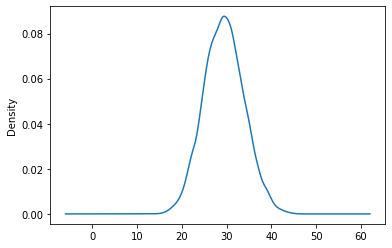

In [64]:
final_df[final_df.name == 'політична партія всеукраїнське обєднання свобода'].n.plot.density()

In [24]:
df = pd.read_csv('combined_results_cleaned.csv')

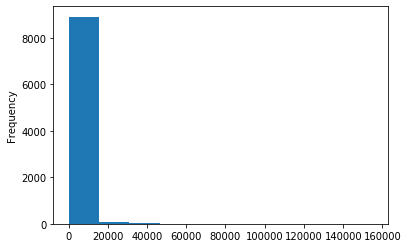

In [25]:
df.funding.plot.hist()

In [31]:
df.prop_election_forecast.unique()

array([30.7,  nan, 12.9, 19.5, 22.1,  6.5, 23. ,  5.6, 13.2,  6.4,  7.6,
       21.3,  6.3,  8.3, 12. ,  3.9, 45.5,  7.2,  6.6])

In [16]:
df.loc[(df.year == 2012) & (df.winner == True)].proposed.value_counts()

партія регіонів                                                                     115
самовисування                                                                        45
політична партія всеукраїнське обєднання батьківщина                                 40
політична партія всеукраїнське обєднання свобода                                     12
політична партія удар український демократичний альянс за реформи віталія кличка      6
політична партія єдиний центр                                                         3
народна партія                                                                        2
радикальна партія олега ляшка                                                         1
партія союз                                                                           1
Name: proposed, dtype: int64

In [14]:
import pandas as pd
df = pd.read_csv('combined_results_cleaned.csv')

In [13]:
df

,deputat,perc_for,votes_for,tvo,oblast,year,info,proposed,registration,gender,...,winner,average_age,pop_change,region_ideology,previous,ever,funding,power_status,party_ideology,prop_election_forecast
0,Дзоз Віталіна Олексіївна,38.76,27937.0,1,Автономна Республіка Крим,2012,народилася 16 листопада 1955 року в місті Крив...,партія регіонів,2012-08-07,F,...,True,40.4,1.1,blue,False,False,0,yes,blue,30.7
1,Грач Леонід Іванович,17.98,12960.0,1,Автономна Республіка Крим,2012,народився 1 сiчня 1948 року в селі Бродецьке К...,самовисування,2012-08-03,M,...,False,40.4,1.1,blue,True,True,0,no,grey,NaN
2,Соломахін Олег Андрійович,10.58,7630.0,1,Автономна Республіка Крим,2012,"народився 24 червня 1960 року в місті Херсоні,...",комуністична партія україни,2012-08-03,M,...,False,40.4,1.1,blue,False,False,0,yes,blue,12.9
3,Аксенов Сергій Валерійович,9.12,6575.0,1,Автономна Республіка Крим,2012,народився 26 листопада 1972 року в місті Бєльц...,політична партія руська єдність,2012-08-15,M,...,False,40.4,1.1,blue,False,False,0,no,blue,NaN
4,Доценко Сергій Миколайович,6.71,4838.0,1,Автономна Республіка Крим,2012,народився 27 липня 1979 року в селі Ромашкине ...,політична партія удар український демократични...,2012-08-09,M,...,False,40.4,1.1,blue,False,False,0,no,orange,19.5
5,Лобачев Сергій Миколайович,6.22,4485.0,1,Автономна Республіка Крим,2012,народився 10 червня 1944 року в селі Абезь Інт...,політична партія всеукраїнське обєднання батьк...,2012-08-08,M,...,False,40.4,1.1,blue,False,False,0,no,orange,22.1
6,Семенова Лариса Іванівна,2.28,1646.0,1,Автономна Республіка Крим,2012,народилася 12 лютого 1954 року в місті Євпатор...,партія зелених україни,2012-08-13,F,...,False,40.4,1.1,blue,False,False,0,no,grey,NaN
7,Толкачов Володимир Володимирович,1.55,1119.0,1,Автономна Республіка Крим,2012,народився 15 листопада 1964 року в місті Сімфе...,партія наталії королевської україна вперед,2012-08-11,M,...,False,40.4,1.1,blue,False,False,0,no,blue,NaN
8,Пузако Володимир Іванович,1.17,847.0,1,Автономна Республіка Крим,2012,народився 16 липня 1951 року в місті Біла Церк...,українська партія зелена планета,2012-08-14,M,...,False,40.4,1.1,blue,False,False,0,no,grey,NaN
9,Волков Олександр Петрович,0.88,635.0,1,Автономна Республіка Крим,2012,народився 6 вересня 1946 року в радгоспі Перво...,самовисування,2012-08-10,M,...,False,40.4,1.1,blue,False,False,0,no,grey,NaN


In [8]:
df.prop_election_forecast.unique()

array([30.7,  nan, 12.9, 19.5, 22.1,  6.5, 23. ,  5.6, 13.2,  6.4,  7.6,
       21.3,  6.3,  8.3, 12. ,  3.9, 45.5,  7.2,  6.6])

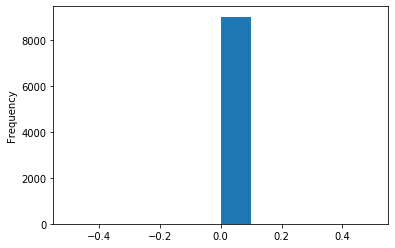

In [6]:
df.funding.plot.hist()

## final prediction distribution


In [127]:
import pandas as pd

In [128]:
import ipdb

def modeling_parties_as_function(df, col_name, number_of_winners, number_of_trials):
    from tqdm import tqdm_notebook as tqdm
    
    def check_if_smaller(list_of_pred, number):
#         list_of_pred = list_of_pred[::-1]
        if (list_of_pred[0] > number):
            return list_of_pred[0]
        if (list_of_pred[0] + list_of_pred[1] > number):
            return list_of_pred[1]
        if (list_of_pred[0] + list_of_pred[1] + list_of_pred[2] > number):
            return list_of_pred[2]
        if (list_of_pred[0] + list_of_pred[1] + list_of_pred[2] + list_of_pred[3] > number):
            return list_of_pred[3]
        else:
            return list_of_pred[4]
        
        
    df['tvo'] = df.tvo.astype('object')

    
#     for full data, to get top 5 results
    df = (df.sort_values(col_name, ascending=False)
                           .groupby('tvo').head(number_of_winners).sort_values('tvo'))
    
    df['true_prob_sum'] = df.groupby('tvo')[col_name].transform(sum)
    df['true_prob_two_1'] = df[col_name] / df.true_prob_sum
    
    
    
    prob = (df.sort_values('true_prob_two_1', ascending=False).groupby('tvo')
                 .apply(lambda x: [list(x['true_prob_two_1'].values), 
                                   list(x['proposed'].values),
                                    list(x['deputat'])]
                        ).reset_index(name = 'prob'))
#     ipdb.set_trace()
    prob['prob_value'] = prob.prob.str[0]
    prob['party_list'] = prob.prob.str[1]
    prob['deputat'] = prob.prob.str[2]


#     generating random trials
    random_modeling = [np.random.normal(0.5, 0.25,size=number_of_trials) for a in range(0,199)]
    
#     for situation with the same probability
    prob['prob_full'] = prob['prob_value'] + np.random.normal(0.00001, 0.00002,size=1)


    res = []
    for a in (range(0,len(prob.prob_full))):
#         ipdb.set_trace()
        res.append([check_if_smaller(prob.prob_full[a], b) for b in random_modeling[a]])


    prob['res'] = res

    def find_winner_party(x):
#         ipdb.set_trace()
        dictionary = dict(zip(x['prob_full'], x['party_list']))
        return [dictionary[d] for d in x['res']]


    prob['winner_party'] = prob.apply(lambda x: find_winner_party(x), axis=1)

    final = []
    for number in (range(0,number_of_trials)):
        final.append(pd.DataFrame({'name':prob.winner_party.str[number].value_counts().index,
         'n': prob.winner_party.str[number].value_counts().values,
         'trial': number
        }))


    final_df = pd.concat(final)
    return final_df




In [129]:
pred = pd.read_csv('new_prediction.csv')

In [242]:
# pred.loc[pred.proposed == 'самовисування', 'proposed'] =  pred.loc[pred.proposed == 'самовисування', 'fraction']

In [5]:
pred_modeling_150 = modeling_parties_as_function(pred, 'prediction_150', 5, 1000)
pred_modeling_100 = modeling_parties_as_function(pred, 'prediction_100', 5, 1000)
pred_modeling_50 = modeling_parties_as_function(pred, 'prediction_50', 5, 1000)
pred_modeling_default_plus_class = modeling_parties_as_function(pred, 'prediction_default_plus_class', 5, 1000)

In [6]:
def chart(party_name, title, color):
    import numpy as np
    import seaborn as sns; sns.set(color_codes=True)
    from matplotlib.ticker import MaxNLocator

    x = pred_modeling_default_plus_class[pred_modeling_default_plus_class.name == party_name].n

    # ax = sns.kdeplot(x)
    ax = sns.distplot(x, kde=False, color=color, bins=np.arange(x.min(), x.max() + 1))
    ax.set_title(title, weight='bold')
    ax.set(xlabel='')
    

    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    
    
    sns.set(rc={'figure.figsize':(4.2,2.4)})

    legend = ax.legend()
    legend.remove()

    ax.set(yticks=[])

No handles with labels found to put in legend.


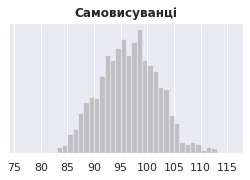

In [9]:
# chart('політична партія слуга народу', "Слуга Народу", 'green')
chart('самовисування', "Самовисуванці", 'grey')
# chart('політична партія опозиційна платформа  за життя', "Опозиційна Платформа - За Життя", 'blue')
# chart('політична партія європейська солідарність', "Європейська Солідарність", 'red')
# chart('політична партія голос', "Партія Голос", 'orange')
# chart('політична партія всеукраїнське обєднання батьківщина', "ВО Батьківщина", 'pink')


# дуже мало 
# chart('політична партія сила і честь', "Сила і Честь", 'violet')


In [17]:
pred_modeling_default_plus_class.groupby('name').n.median().reset_index(name='mean').sort_values('mean', ascending=False)

,name,mean
24,самовисування,96
16,політична партія слуга народу,71
20,політична партія європейська солідарність,10
10,політична партія опозиційна платформа за життя,7
4,політична партія голос,4
2,політична партія всеукраїнське обєднання батьк...,3
3,політична партія всеукраїнське обєднання свобода,2
21,політична партія єдиний центр,2
0,аграрна партія україни,1
15,політична партія сила і честь,1


In [170]:
samovys = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSNxiVppRf_pyTzKIXI-NA-5ncgsmjr8EmKSNUlarYzpdVC12ToK80zDjDXRkWvw_lmF6ng-yoTRMvP/pub?gid=812690743&single=true&output=csv')

In [177]:
temp = samovys.fraction.value_counts().reset_index(name='n')
temp['perc'] = temp.n/temp.n.sum() * 100

In [289]:
# pred_modeling_150.name.value_counts()

samov = [
'Член депутатської фракції ПАРТІЇ "БЛОК ПЕТРА ПОРОШЕНКА"', 
'Член депутатської фракції Політичної партії "НАРОДНИЙ ФРОНТ"',
'Член депутатської групи "Партія "Відродження"',
'Член депутатської групи "Воля народу"',
'Член депутатської фракції Політичної партії "Опозиційний блок"',
'Член депутатської фракції Радикальної партії Олега Ляшка',
]




In [287]:
pred_modeling_default_plus_class.groupby('name')['n'].median().reset_index(name='mean_n').sort_values('mean_n', ascending=False)

,name,mean_n
24,політична партія слуга народу,71
4,"Член депутатської фракції ПАРТІЇ ""БЛОК ПЕТРА П...",36
5,"Член депутатської фракції Політичної партії ""Н...",17
3,"Член депутатської групи ""Партія ""Відродження""",12
28,політична партія європейська солідарність,10
2,"Член депутатської групи ""Воля народу""",9
6,"Член депутатської фракції Політичної партії ""О...",7
18,політична партія опозиційна платформа за життя,7
12,політична партія голос,4
7,Член депутатської фракції Радикальної партії О...,3


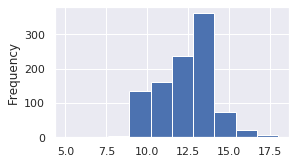

In [331]:
pred_modeling_default_plus_class.loc[pred_modeling_default_plus_class.name == 'Член депутатської групи "Партія "Відродження"'].n.plot.hist()

No handles with labels found to put in legend.


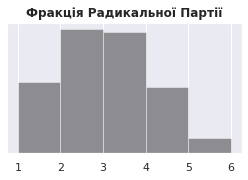

In [430]:
xz = samov
# chart(xz[0], 'Фракція БПП', 'red')
# chart(xz[1], 'Фракція Народного Фронту', 'yellow')
# chart(xz[2], 'Група Відродження', 'purple')
# chart(xz[3], 'Група Воля Народу', 'silver')
# chart(xz[4], 'Фракція Опозиційного Блоку', 'blue')
# chart(xz[5], 'Фракція Радикальної Партії', 'black')



# checking the model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [2]:
from numpy import loadtxt
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
import sklearn
import shap
import matplotlib.pyplot as plt


In [3]:
df_old = pd.read_csv('combined_results_cleaned.csv')
df_new = pd.read_csv('rerun_model_actual_data_2019.csv')


In [23]:
# трьох депутатів-переможців не було у файлі rerun_model_actual_data_2019.csv, 
# я їх взяв з combined_results_cleaned.csv і додав
lost_deputats = df_old[df_old.deputat.isin(['МяликВіктор Ничипорович',
                                            'Мінько Сергій Анатолійович',
                                            'МедяникВячеслав Анатолійович']) &
                                          (df_old.year == 2019) &
                                          (df_old.registration != '2019-06-29')]

lost_deputats.winner = True
lost_deputats.proposed = ['самовисування', 'самовисування', 'політична партія слуга народу']

# united data
df_total = pd.concat([df_old[df_old.year != 2019], df_new[df_new.year == 2019], lost_deputats])


df_total = df_total[~((df_total.year == 2019) & (df_total.winner.isnull()))]

df_total.winner = df_total.winner.astype('bool')

used_by_Isiah =["tvo", "oblast", "year", "proposed", "gender", "age", "party",
                  "average_age", "pop_change", "previous", "ever", "job", "funding",
                  "region_ideology", "power_status", "party_ideology","pres_perc_for",
                "prop_election_forecast", 'winner', 'votes_for', 'perc_for']

used_by_Isiah_without_proposed_and_power_status =[ "tvo", "oblast", "year", "gender", "age", "party",
                  "average_age", "pop_change", "previous", "ever", "job", "funding",
                  "region_ideology", "party_ideology","pres_perc_for",
                "prop_election_forecast", 'winner', 'votes_for', 'perc_for', 'pres_perc_for']


/home/ptrbdr/files/parliamentary_elections/env/lib/python3.5/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/ptrbdr/files/parliamentary_elections/env/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [367]:
# так правильно, але цього н бе було в стартовій моделі
# df_total.power_status = df_total.power_status == 'yes'

In [381]:
# population_votes = pd.read_csv('turnover.csv')
# df_total = pd.merge(df_total, population_votes[['tvo', 'turnover']], on='tvo', how='left')

In [24]:
class ModelDescr():
    def __init__(self):
        self.year = None
        self.data = None
        self.model = None
        self.dummies = None 
        self.train = None 
        self.Y_train = None 
        self.test = None
        self.Y_test = None
        
        self.explainer = None
        self.shap_values = None
        
        
        
    def set_data(self, data, year):
#         setter
        self.year = year
        self.data = data[data.year == year]
        self.do_the_modeling()
        
#       plots
        shap.initjs()
        
        
        self.explainer = shap.TreeExplainer(self.model)
        self.shap_values = self.explainer.shap_values(self.train)

    
        
    def do_the_modeling(self):
        df_total = self.data
        
        for d in ['proposed', 'gender', 'job', 'city_living', 'party', 'tvo_pres',
         'pres_candidate', 'region_ideology', 'party_ideology', 'oblast']:
            df_total[d] = df_total[d].astype('category')

        df_total = df_total[used_by_Isiah]

    #     df_total = df_total.drop(['info', 'city_living', 'deputat', 'registration',
    #                      'tvo_pres', 'birthday', 'candidate_url', 'proposed', 'pres_votes_for', 'party', 'turnover'], axis=1)
        dummies = pd.get_dummies(df_total)


        train_inds, test_inds = (next(GroupShuffleSplit(test_size=.20, n_splits=3, random_state = 7)
                                     .split(dummies, groups=dummies['tvo'])))

        train = dummies.iloc[train_inds]
        test = dummies.iloc[test_inds]

        Y_train = train[['winner', 'votes_for']]
        Y_test = test[['winner', 'votes_for']]

        train = train.drop(['winner', 'votes_for', 'perc_for'], axis=1)
        test = test.drop(['winner', 'votes_for', 'perc_for'], axis=1)

        print('done data split')


        # fit model no training data
        model = XGBClassifier(
            ntrees = 150,
            eta = 0.1,
            min_child_weight = 9,        ## very imbalanced
            max_depth = 11,
            gamma = 0,                   ## should be tuned, depends on logloss function
            max_delta_step = 0,          ## defaults to 0, can be helpful in unbalanced models
            subsample = 0.8,             ## defaults to 1, lowering prevents overfit
            colsample_bytree = 0.8,      ## fraction of columns to samples for each tree
            stopping_rounds = 50,
            stopping_metric = "logloss",
            verbose = True,
        )
        model.fit(train, Y_train.winner)
        
        self.model = model
        self.dummies = dummies 
        self.train = train 
        self.Y_train = Y_train 
        self.test = test
        self.Y_test = Y_test
        
        
    def get_prediction(self, data):
        return self.model.predict(data)
    
    def plot_conf(self):
        np.set_printoptions(precision=2)

        # Plot non-normalized confusion matrix
        plot_confusion_matrix(self.Y_test.winner, self.model.predict(self.test), classes=[False,True],
                              title='Confusion matrix, without normalization')

        # Plot normalized confusion matrix
        # plot_confusion_matrix(y_test.values, y_pred, classes=[False,True],normalize=True,
        #                       title='Normalized confusion matrix')

        plt.show()
        
        
    def print_scores(self):
        print('accuracy_score ' + str(sklearn.metrics.accuracy_score(self.Y_test.winner, self.model.predict(self.test))) + '\n')
        print('recall_score ' + str(sklearn.metrics.recall_score(self.Y_test.winner, self.model.predict(self.test))) + '\n')
        print('precision_score ' + str(sklearn.metrics.precision_score(self.Y_test.winner, self.model.predict(self.test))) + '\n')
        print('f1_score ' + str(sklearn.metrics.f1_score(self.Y_test.winner, self.model.predict(self.test))) + '\n')

        
    def get_importance_score(self):
        importance_xgb_model = pd.DataFrame({'columns': self.test.columns,
                                     'importance': self.model.feature_importances_}).sort_values('importance',
                                                                                            ascending=False)
        return importance_xgb_model
    
    def plot_importance(self, importance_type='gain', save_plot=False, plot_name='plots/importance_plot.png'):
        ax = xgboost.plot_importance(self.model, importance_type=importance_type,
                             title='Важливість змінної для моделі за даними ' + str(self.year) + ' року',
                             show_values=False, xlabel = None,
                             ylabel = None, grid=False)
        fig = ax.figure
        fig.set_size_inches(10, 8, forward=True)
        
        if (save_plot):
            plt.savefig(plot_name, bbox_inches='tight', pad_inches=1)
        
        
    def plot_shap_dependence_plot(self, number_of_variables=10):
        for name in self.get_importance_score().head(number_of_variables)['columns']:
            shap.dependence_plot(name, self.shap_values, self.train)
            
            
    def plot_shap_force_plot(self):
        shap.force_plot(self.explainer.expected_value, self.shap_values[0,:], self.train.iloc[0,:], matplotlib=True)
        

    def plot_shap_summary_plot_bar(self):
        shap.summary_plot(self.shap_values, self.train, plot_type="bar")
        
        
    def plot_shap_summary_plot_violine(self, save_plot=False, name='plot/summary_plot.png'):
        shap.summary_plot(self.shap_values, self.train, show=False)
    
        import matplotlib.pyplot as pl
        figure = pl.gcf()
        figure.set_size_inches(10, 12)
        
        if (save_plot):
            pl.savefig(name, bbox_inches='tight', pad_inches=1)

    



    

In [55]:
model_check = ModelDescr()
model_check.set_data(df_total, 2014)

/home/ptrbdr/files/parliamentary_elections/env/lib/python3.5/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


done data split


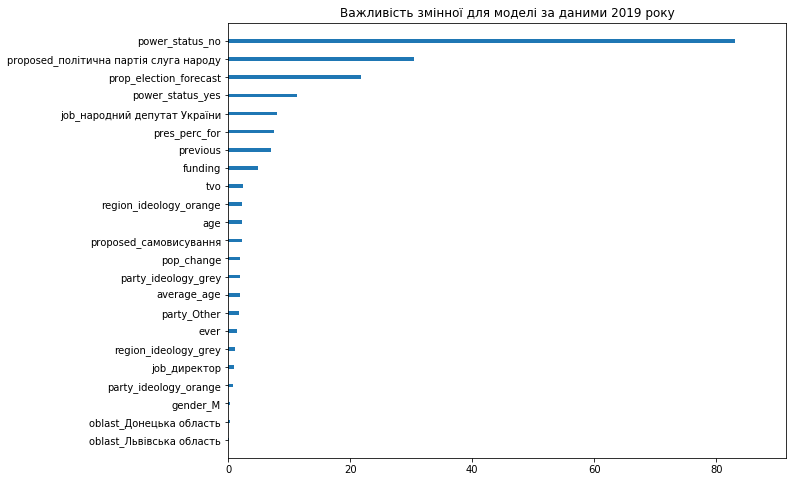

In [50]:
model_check.plot_importance()

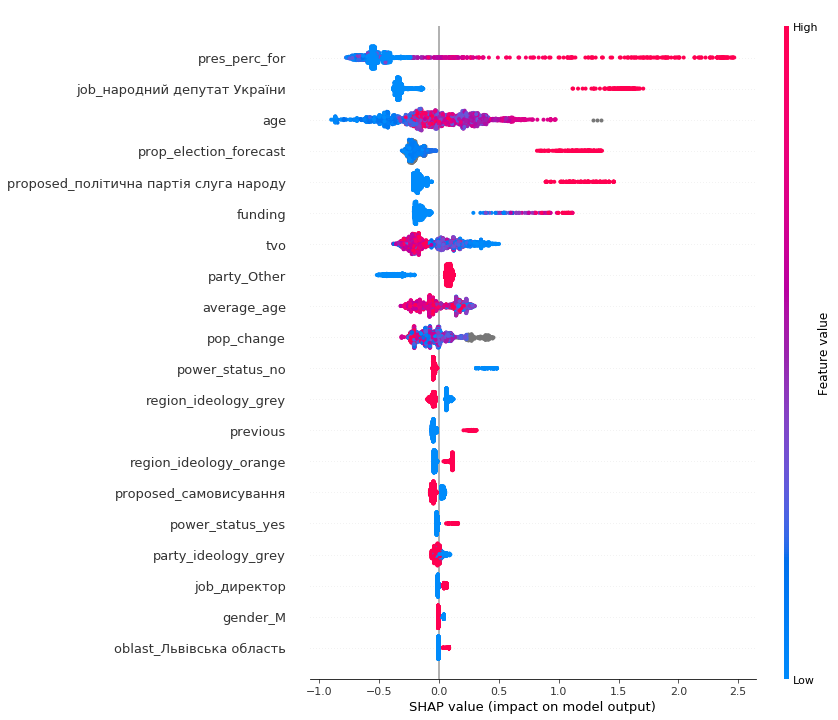

In [51]:
model_check.plot_shap_summary_plot_violine()

In [ ]:
model_check.plot_shap_summary_plot_violine

In [315]:
# shap.force_plot(explainer.expected_value, shap_values[:1000,:], train.iloc[:1000,:])

In [ ]:
# https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

## logistic regression

In [ ]:
len(df_total[(df_total.year == 2019) &
         (df_total.winner == True) &
         (df_total.proposed == 'політична партія слуга народу') 
        ])

In [ ]:
import sklearn
log_regression = sklearn.linear_model.LogisticRegression()

In [ ]:
train = train.fillna(0)
test = test.fillna(0)

In [ ]:
log_regression.fit(train, Y_train.winner)

In [ ]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test.winner, log_regression.predict(test), classes=[False,True],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(y_test.values, y_pred, classes=[False,True],normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [ ]:
print('accuracy_score ' + str(sklearn.metrics.accuracy_score(Y_test.winner, log_regression.predict(test))) + '\n')
print('recall_score ' + str(sklearn.metrics.recall_score(Y_test.winner, log_regression.predict(test))) + '\n')
print('precision_score ' + str(sklearn.metrics.precision_score(Y_test.winner, log_regression.predict(test))) + '\n')
print('f1_score ' + str(sklearn.metrics.f1_score(Y_test.winner, log_regression.predict(test))) + '\n')

In [ ]:
feature_importance_lr = pd.DataFrame({'features':test.columns.values, 'coef':log_regression.coef_[0]})
feature_importance_lr.sort_values('coef', ascending=False)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
X = test  #independent columns
y = Y_test    #target column i.e price range
#get correlations of each features in dataset
corrmat = df_total.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_total[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# get tvo population

In [ ]:
import pandas as pd
import requests 
import bs4
import ipdb

tvo_population = []
for i in df_total[df_total.year == 2019].tvo.unique():
    response = requests.get("https://www.cvk.gov.ua/pls/vnd2019/wp338pt001f01=919pf7331=" + str(i) + ".html")
    t = pd.read_html(response.content)[1]
    t['tvo'] = i
    tvo_population.append(t)


In [ ]:
population = pd.concat(tvo_population)

In [ ]:
population_votes = population.groupby('tvo', as_index=False)['7) Сумарна к-сть виборців, які отримали бюлетені',
                          '1) К-сть одержаних бюлетенів'].sum()

In [ ]:
population_votes.columns = ['tvo', 'total_votes', 'total_people']

In [57]:
population_votes['turnover'] = population_votes.total_votes/population_votes.total_people * 100

In [59]:
population_votes.sort_values('turnover', ascending=False)

,tvo,total_votes,total_people,turnover
164,189,81529,143912,56.651982
7,18,77712,137336,56.585309
185,210,80072,141783,56.475036
140,165,97010,172208,56.333039
141,166,91450,163396,55.968322
123,148,79380,142236,55.808656
94,119,83541,150564,55.485375
122,147,74476,135216,55.079281
136,161,74609,136128,54.807975
101,126,81254,148308,54.787334


In [61]:
population_votes.to_csv('turnover.csv', index=False)